In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Ipynb_importer
from utils_x import *
from parameters_x import *
import seaborn as sns
import datetime
from scipy.stats import norm
sns.set(style="darkgrid")
import logging
import time



importing Jupyter notebook from utils_x.ipynb
importing Jupyter notebook from parameters_x.ipynb


In [2]:
print("----------------- load data--------------------")
data = pd.read_csv('index500_v3_adjustment_new.csv', index_col=0)
begin_interval_df = pd.read_csv('begin_930_interval_df.csv', index_col=0)
data["date_time"]  = pd.to_datetime(data["date_time"])
begin_interval_df["date_time"] = pd.to_datetime(begin_interval_df["date_time"])


----------------- load data--------------------


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
index_df = pd.read_csv('index500_open.csv', index_col=0)
index_df["date_time"]  = pd.to_datetime(index_df["date_time"])

In [116]:
future_df = pd.read_csv('future500_open.csv', index_col=0)
future_df["date_time"]  = pd.to_datetime(future_df["date_time"])

In [4]:
data = pd.merge(data, begin_interval_df, how="left", on=['unique_symbol','date_time'])

In [5]:
data = pd.merge(data, index_df, how="left", on=['date_time'])

In [118]:
data = pd.merge(data, future_df, how="left", on=['date_time'])

In [6]:
data[["date_time", "index500_return"]]

,date_time,index500_return
0,2010-01-29,-0.005141
1,2010-01-29,-0.005141
2,2010-01-29,-0.005141
3,2010-01-29,-0.005141
4,2010-01-29,-0.005141
...,...,...
4560223,2017-12-27,0.006082
4560224,2017-12-27,0.006082
4560225,2017-12-27,0.006082
4560226,2017-12-27,0.006082


In [7]:
print("----------------- limit_tag--------------------")
gb = data.groupby(['unique_symbol'])['adjustment_cumsum']
data['t+1_adjustment_cumsum'] = gb.transform(lambda x: x.shift(-1))
data["r1"]  = (data["t+1_close_mid"] - data["t+1_adjustment_cumsum"] + data["adjustment_cumsum"]) /data["close"] -1
data["limit_tag"] = data["r1"].apply(lambda x: 1 if x >= 0.099 else 0)

----------------- limit_tag--------------------


In [8]:
p_col = ['close', 'open', 'high', 'low', 'wap']
v_col = ['turnover', 'volume']
n_shift = 15
vol_factor1 = []
for factor_name in v_col:
    for i in range(1, n_shift):
        vol_factor1.append(factor_name + str(i))

vol_factor2 = []
gb = data.groupby(['unique_symbol'])
for factor_name in v_col:
    for i in range(1, n_shift):
        print("sum_" + factor_name + str(i))
        data["sum_" + factor_name + str(i)] = gb[factor_name].transform(lambda x: x.rolling(window=i).sum())
        vol_factor2.append("sum_" + factor_name + str(i))

return_factor = []
for factor_name in p_col:
    for i in range(1,n_shift):
        return_factor.append(factor_name + str(i))

sum_turnover1
sum_turnover2
sum_turnover3
sum_turnover4
sum_turnover5
sum_turnover6
sum_turnover7
sum_turnover8
sum_turnover9
sum_turnover10
sum_turnover11
sum_turnover12
sum_turnover13
sum_turnover14
sum_volume1
sum_volume2
sum_volume3
sum_volume4
sum_volume5
sum_volume6
sum_volume7
sum_volume8
sum_volume9
sum_volume10
sum_volume11
sum_volume12
sum_volume13
sum_volume14


In [9]:
vol_factor3 = []
gb = data.groupby(['date_time'])
data["cont"] = gb["unique_symbol"].transform(lambda x: x.count())
data["cont"] = data["cont"] + 1
for factor_name in v_col:
    for i in range(1, n_shift):
        print("norm_" + factor_name + str(i))
        data["norm_" + factor_name + str(i)] = gb["sum_" + factor_name + str(i)].transform(lambda x: x.rank())
        data["norm_" + factor_name + str(i)] = data["norm_" + factor_name + str(i)] / data["cont"]
        data["norm_" + factor_name + str(i)] = data["norm_" + factor_name + str(i)].apply(lambda x: InverseNormalCDF(x))
        vol_factor3.append("norm_" + factor_name + str(i))

norm_turnover1
norm_turnover2
norm_turnover3
norm_turnover4
norm_turnover5
norm_turnover6
norm_turnover7
norm_turnover8
norm_turnover9
norm_turnover10
norm_turnover11
norm_turnover12
norm_turnover13
norm_turnover14
norm_volume1
norm_volume2
norm_volume3
norm_volume4
norm_volume5
norm_volume6
norm_volume7
norm_volume8
norm_volume9
norm_volume10
norm_volume11
norm_volume12
norm_volume13
norm_volume14


In [10]:
print("------------------- label --------------------")
gb = data.groupby(["unique_symbol"])
data["t+2_open"] = gb["open"].transform(lambda x: x.shift(-2))
data["y_open"] = data["t+2_open"] - data['t+2_adjustment']
data['return'] = data.apply(lambda x: (x['y_open'])/x['t+1_open']-1, axis=1)


data =  data[data["use_tag"] == 1].copy()
gb = data.groupby(['date_time'])['return']
data['label'] = gb.transform(lambda x: (x-x.mean())/x.std())
data['mr'] = gb.transform(lambda x: x.mean())

------------------- label --------------------


In [11]:
gb = data.groupby(["date_time"])
for t,ddf in gb:
    print(t, len(ddf))

2010-01-29 00:00:00 492
2010-02-01 00:00:00 491
2010-02-02 00:00:00 491
2010-02-03 00:00:00 494
2010-02-04 00:00:00 497
2010-02-05 00:00:00 491
2010-02-08 00:00:00 488
2010-02-09 00:00:00 492
2010-02-10 00:00:00 495
2010-02-11 00:00:00 494
2010-02-12 00:00:00 497
2010-02-22 00:00:00 494
2010-02-23 00:00:00 492
2010-02-24 00:00:00 496
2010-02-25 00:00:00 491
2010-02-26 00:00:00 488
2010-03-01 00:00:00 486
2010-03-02 00:00:00 482
2010-03-03 00:00:00 490
2010-03-04 00:00:00 493
2010-03-05 00:00:00 487
2010-03-08 00:00:00 492
2010-03-09 00:00:00 495
2010-03-10 00:00:00 496
2010-03-11 00:00:00 497
2010-03-12 00:00:00 490
2010-03-15 00:00:00 494
2010-03-16 00:00:00 494
2010-03-17 00:00:00 493
2010-03-18 00:00:00 491
2010-03-19 00:00:00 487
2010-03-22 00:00:00 488
2010-03-23 00:00:00 490
2010-03-24 00:00:00 492
2010-03-25 00:00:00 482
2010-03-26 00:00:00 485
2010-03-29 00:00:00 487
2010-03-30 00:00:00 481
2010-03-31 00:00:00 478
2010-04-01 00:00:00 492
2010-04-02 00:00:00 481
2010-04-06 00:00

2011-09-22 00:00:00 485
2011-09-23 00:00:00 489
2011-09-26 00:00:00 490
2011-09-27 00:00:00 487
2011-09-28 00:00:00 489
2011-09-29 00:00:00 488
2011-09-30 00:00:00 491
2011-10-10 00:00:00 489
2011-10-11 00:00:00 490
2011-10-12 00:00:00 490
2011-10-13 00:00:00 487
2011-10-14 00:00:00 479
2011-10-17 00:00:00 480
2011-10-18 00:00:00 481
2011-10-19 00:00:00 487
2011-10-20 00:00:00 491
2011-10-21 00:00:00 491
2011-10-24 00:00:00 494
2011-10-25 00:00:00 493
2011-10-26 00:00:00 484
2011-10-27 00:00:00 487
2011-10-28 00:00:00 490
2011-10-31 00:00:00 488
2011-11-01 00:00:00 489
2011-11-02 00:00:00 487
2011-11-03 00:00:00 487
2011-11-04 00:00:00 485
2011-11-07 00:00:00 481
2011-11-08 00:00:00 481
2011-11-09 00:00:00 481
2011-11-10 00:00:00 479
2011-11-11 00:00:00 477
2011-11-14 00:00:00 478
2011-11-15 00:00:00 477
2011-11-16 00:00:00 483
2011-11-17 00:00:00 483
2011-11-18 00:00:00 479
2011-11-21 00:00:00 482
2011-11-22 00:00:00 485
2011-11-23 00:00:00 486
2011-11-24 00:00:00 488
2011-11-25 00:00

2013-04-26 00:00:00 493
2013-05-02 00:00:00 492
2013-05-03 00:00:00 492
2013-05-06 00:00:00 490
2013-05-07 00:00:00 492
2013-05-08 00:00:00 492
2013-05-09 00:00:00 493
2013-05-10 00:00:00 492
2013-05-13 00:00:00 491
2013-05-14 00:00:00 490
2013-05-15 00:00:00 490
2013-05-16 00:00:00 490
2013-05-17 00:00:00 489
2013-05-20 00:00:00 485
2013-05-21 00:00:00 486
2013-05-22 00:00:00 487
2013-05-23 00:00:00 487
2013-05-24 00:00:00 488
2013-05-27 00:00:00 485
2013-05-28 00:00:00 485
2013-05-29 00:00:00 485
2013-05-30 00:00:00 485
2013-05-31 00:00:00 487
2013-06-03 00:00:00 484
2013-06-04 00:00:00 485
2013-06-05 00:00:00 485
2013-06-06 00:00:00 485
2013-06-07 00:00:00 482
2013-06-13 00:00:00 479
2013-06-14 00:00:00 483
2013-06-17 00:00:00 482
2013-06-18 00:00:00 484
2013-06-19 00:00:00 485
2013-06-20 00:00:00 483
2013-06-21 00:00:00 484
2013-06-24 00:00:00 480
2013-06-25 00:00:00 482
2013-06-26 00:00:00 482
2013-06-27 00:00:00 484
2013-06-28 00:00:00 486
2013-07-01 00:00:00 488
2013-07-02 00:00

2014-12-03 00:00:00 464
2014-12-04 00:00:00 465
2014-12-05 00:00:00 467
2014-12-08 00:00:00 467
2014-12-09 00:00:00 465
2014-12-10 00:00:00 465
2014-12-11 00:00:00 465
2014-12-12 00:00:00 465
2014-12-15 00:00:00 465
2014-12-16 00:00:00 467
2014-12-17 00:00:00 465
2014-12-18 00:00:00 468
2014-12-19 00:00:00 468
2014-12-22 00:00:00 465
2014-12-23 00:00:00 465
2014-12-24 00:00:00 463
2014-12-25 00:00:00 464
2014-12-26 00:00:00 462
2014-12-29 00:00:00 460
2014-12-30 00:00:00 464
2014-12-31 00:00:00 466
2015-01-05 00:00:00 465
2015-01-06 00:00:00 468
2015-01-07 00:00:00 466
2015-01-08 00:00:00 467
2015-01-09 00:00:00 466
2015-01-12 00:00:00 464
2015-01-13 00:00:00 464
2015-01-14 00:00:00 466
2015-01-15 00:00:00 464
2015-01-16 00:00:00 467
2015-01-19 00:00:00 464
2015-01-20 00:00:00 464
2015-01-21 00:00:00 464
2015-01-22 00:00:00 464
2015-01-23 00:00:00 464
2015-01-26 00:00:00 466
2015-01-27 00:00:00 467
2015-01-28 00:00:00 465
2015-01-29 00:00:00 469
2015-01-30 00:00:00 469
2015-02-02 00:00

2016-07-04 00:00:00 475
2016-07-05 00:00:00 474
2016-07-06 00:00:00 475
2016-07-07 00:00:00 476
2016-07-08 00:00:00 475
2016-07-11 00:00:00 477
2016-07-12 00:00:00 477
2016-07-13 00:00:00 476
2016-07-14 00:00:00 477
2016-07-15 00:00:00 477
2016-07-18 00:00:00 475
2016-07-19 00:00:00 475
2016-07-20 00:00:00 473
2016-07-21 00:00:00 477
2016-07-22 00:00:00 478
2016-07-25 00:00:00 478
2016-07-26 00:00:00 479
2016-07-27 00:00:00 479
2016-07-28 00:00:00 479
2016-07-29 00:00:00 477
2016-08-01 00:00:00 478
2016-08-02 00:00:00 480
2016-08-03 00:00:00 480
2016-08-04 00:00:00 481
2016-08-05 00:00:00 483
2016-08-08 00:00:00 483
2016-08-09 00:00:00 482
2016-08-10 00:00:00 481
2016-08-11 00:00:00 481
2016-08-12 00:00:00 481
2016-08-15 00:00:00 481
2016-08-16 00:00:00 482
2016-08-17 00:00:00 482
2016-08-18 00:00:00 481
2016-08-19 00:00:00 480
2016-08-22 00:00:00 482
2016-08-23 00:00:00 481
2016-08-24 00:00:00 482
2016-08-25 00:00:00 480
2016-08-26 00:00:00 479
2016-08-29 00:00:00 479
2016-08-30 00:00

2017-12-20 00:00:00 470
2017-12-21 00:00:00 468
2017-12-22 00:00:00 467
2017-12-25 00:00:00 467
2017-12-26 00:00:00 467
2017-12-27 00:00:00 469


In [12]:
params = {
    'task': 'train',
    'booster': 'dart',
#     'boosting_type': 'gbdt',
#     'eta': 0.15,
    'max_depth': 6,
#     'lambda': 5,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'gamma': 5,
#     'rate_drop': 0.1,
#     'skip_drop': 0.5,
    'nthread': 10,
    'alpha': 100
         }
num_rounds =1000
early = 50

In [13]:
# 训练日志
logger = logging.getLogger(__name__)
logger.setLevel(level = logging.INFO)
handler = logging.FileHandler("log/log" + str(time.ctime()) + ".txt")
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
console = logging.StreamHandler()
console.setLevel(logging.INFO)
logger.addHandler(handler)
logger.addHandler(console)

In [14]:
print("---------------- add factor--------------------")

data["r"] = data["close"]/ data["open"] - 1
data["amplitude"] = (data["high"] - data["low"]) / data["close"]
data["amplitude_ratio"] =  abs((data["close"] - data["open"])/(data["high"] - data["low"]))
data["amplitude_ratio"] =  data["amplitude_ratio"].fillna(0)


---------------- add factor--------------------


In [15]:
print("----------------- stationary --------------------")

gb = data.groupby(['date_time'])['r']
data["r_distribute"] = gb.transform(lambda x: (x-x.mean())/x.std())

gb = data.groupby(['date_time'])['r1']
data["r1_distribute"] = gb.transform(lambda x: (x-x.mean())/x.std())

gb = data.groupby(['date_time'])['open']
data['open'] = gb.transform(lambda x: (x-x.mean())/x.std())

data["close_rank"] = data.groupby(['date_time'])['close'].transform( lambda x:x.rank())
data["close_Normal"] = data["close_rank"] / data["cont"]
data["close_Normal"] = data["close_Normal"].apply(lambda x: InverseNormalCDF(x))

gb = data.groupby(['date_time'])['close']
# data['close'] = data["close_Normal"]
data['close'] = gb.transform(lambda x: (x-x.mean())/x.std())
data['close_std'] = data.apply(lambda x : time_series_desribe(x, 5, "close"),axis=1)


data["turnover_rank"] = data.groupby(['date_time'])['turnover'].transform( lambda x:x.rank())
data["turnover"] = data["turnover_rank"] / data["cont"]
data["turnover"] = data["turnover"].apply(lambda x: InverseNormalCDF(x))


data["volume_rank"] = data.groupby(['date_time'])['volume'].transform( lambda x:x.rank())
data["volume"] = data["volume_rank"] / data["cont"]
data["volume"] = data["volume"].apply(lambda x: InverseNormalCDF(x))


----------------- stationary --------------------


In [16]:
print(data["label"].mean())
data = data[~data['return'].isnull()].copy()
print(data["label"].mean())  

1.4443760103713438e-18
1.1788442589697433e-18


In [17]:
intraday_factor = ["r","r_distribute", 'close', 'open', 'turnover', "volume", "amplitude_ratio","close_Normal"]
r1_factor = ["r1","r1_distribute"]
use_f = []
use_f = r1_factor + return_factor + intraday_factor + vol_factor1 + vol_factor2
print("r1_factor:  ", r1_factor, "\n")
print("return_factor:  ", return_factor, "\n")
print("intraday_factor:   ", intraday_factor, "\n")
print("vol_factor1:  ", vol_factor1, "\n")
print("vol_factor2:  ", vol_factor2, "\n")

r1_factor:   ['r1', 'r1_distribute'] 

return_factor:   ['close1', 'close2', 'close3', 'close4', 'close5', 'close6', 'close7', 'close8', 'close9', 'close10', 'close11', 'close12', 'close13', 'close14', 'open1', 'open2', 'open3', 'open4', 'open5', 'open6', 'open7', 'open8', 'open9', 'open10', 'open11', 'open12', 'open13', 'open14', 'high1', 'high2', 'high3', 'high4', 'high5', 'high6', 'high7', 'high8', 'high9', 'high10', 'high11', 'high12', 'high13', 'high14', 'low1', 'low2', 'low3', 'low4', 'low5', 'low6', 'low7', 'low8', 'low9', 'low10', 'low11', 'low12', 'low13', 'low14', 'wap1', 'wap2', 'wap3', 'wap4', 'wap5', 'wap6', 'wap7', 'wap8', 'wap9', 'wap10', 'wap11', 'wap12', 'wap13', 'wap14'] 

intraday_factor:    ['r', 'r_distribute', 'close', 'open', 'turnover', 'volume', 'amplitude_ratio', 'close_Normal'] 

vol_factor1:   ['turnover1', 'turnover2', 'turnover3', 'turnover4', 'turnover5', 'turnover6', 'turnover7', 'turnover8', 'turnover9', 'turnover10', 'turnover11', 'turnover12', 'turnov

In [18]:
use_f = r1_factor + return_factor + intraday_factor + vol_factor1

In [19]:
print(use_f)
print(len(use_f))

['r1', 'r1_distribute', 'close1', 'close2', 'close3', 'close4', 'close5', 'close6', 'close7', 'close8', 'close9', 'close10', 'close11', 'close12', 'close13', 'close14', 'open1', 'open2', 'open3', 'open4', 'open5', 'open6', 'open7', 'open8', 'open9', 'open10', 'open11', 'open12', 'open13', 'open14', 'high1', 'high2', 'high3', 'high4', 'high5', 'high6', 'high7', 'high8', 'high9', 'high10', 'high11', 'high12', 'high13', 'high14', 'low1', 'low2', 'low3', 'low4', 'low5', 'low6', 'low7', 'low8', 'low9', 'low10', 'low11', 'low12', 'low13', 'low14', 'wap1', 'wap2', 'wap3', 'wap4', 'wap5', 'wap6', 'wap7', 'wap8', 'wap9', 'wap10', 'wap11', 'wap12', 'wap13', 'wap14', 'r', 'r_distribute', 'close', 'open', 'turnover', 'volume', 'amplitude_ratio', 'close_Normal', 'turnover1', 'turnover2', 'turnover3', 'turnover4', 'turnover5', 'turnover6', 'turnover7', 'turnover8', 'turnover9', 'turnover10', 'turnover11', 'turnover12', 'turnover13', 'turnover14', 'volume1', 'volume2', 'volume3', 'volume4', 'volume5'

In [20]:
print("-------------------- train -----------------------")
for i in range(1):
    
    t1 = datetime.datetime(2010,1,1)
#     t2 = datetime.datetime(2014,6,1)
#     t3 = datetime.datetime(2015,6,1)
    t2 = datetime.datetime(2013,1,1)
    t3 = datetime.datetime(2015,1,1)
    t4 = datetime.datetime(2018,1,1)
    data_tr = data[ (data["date_time"] >= t1)&(data["date_time"] < t2)]
    data_te = data[ (data["date_time"] >= t2)&(data["date_time"] < t3)]
    data_fin = data[ (data["date_time"] >= t3)&(data["date_time"] < t4)]
    print(len(data_tr["date_time"]))
    print(len(data_te["date_time"]))
    print(len(data_fin["date_time"]))
    
    X_train = data_tr[use_f]
    y_train = data_tr['label']
    X_test = data_te[use_f]
    y_test = data_te['label']

    market_return = list(data[data["date_time"].isin(list(data_fin.date_time))].groupby(['date_time'])['return'].mean())
    logger.info(params)
    bst = train_op(X_train, y_train, params, num_rounds, X_test, y_test, early)  
    importance_dic = f_importance(bst, use_f)
    preds = bst.predict(xgb.DMatrix(data_fin[use_f]), ntree_limit=bst.best_ntree_limit)
    data_fin["preds"] = list(preds)
    preds = bst.predict(xgb.DMatrix(data_te[use_f]), ntree_limit=bst.best_ntree_limit)
    data_te["preds"] = list(preds)
    preds = bst.predict(xgb.DMatrix(data_tr[use_f]), ntree_limit=bst.best_ntree_limit)
    data_tr["preds"] = list(preds)

-------------------- train -----------------------
344737
232728
335694


{'task': 'train', 'booster': 'dart', 'max_depth': 6, 'nthread': 10, 'alpha': 100}
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:1.05635	eval-rmse:1.05726
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:1.02463	eval-rmse:1.02645
[2]	train-rmse:1.00822	eval-rmse:1.01103
[3]	train-rmse:0.999607	eval-rmse:1.0033
[4]	train-rmse:0.995003	eval-rmse:0.999338
[5]	train-rmse:0.992405	eval-rmse:0.997323
[6]	train-rmse:0.990838	eval-rmse:0.996273
[7]	train-rmse:0.989366	eval-rmse:0.995391
[8]	train-rmse:0.988433	eval-rmse:0.995083
[9]	train-rmse:0.987854	eval-rmse:0.994803
[10]	train-rmse:0.987017	eval-rmse:0.994634
[11]	train-rmse:0.986335	eval-rmse:0.994472
[12]	train-rmse:0.985832	eval-rmse:0.994315
[13]	train-rmse:0.985075	eval-rmse:0.99425
[14]	train-rmse:0.984788	eval-rmse:0.994284
[15]	train-rmse:0.98429	eval-rmse:0.994127
[16]	train-rmse:0.983748	eval-rmse:0.99398
[17]	train-rmse:0.983514	eval-rmse:0.994013
[18]	train-rmse:0.983149	eval-rmse:0.994129
[19]	train-rmse:0.982846	eval-rmse:0.99413

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [21]:
# qqq = data_fin[data_fin["t+1_open_mid"].isna()]
# for t,_ in qqq.groupby(["date_time"]):
#     print(t,len(_))

In [22]:
gb = data_fin.groupby(['date_time'])['preds']
rank_level = 10
data_fin["pred_rank"] = gb.transform(lambda x: pd.qcut(x.rank(method='first'), rank_level, labels=False, duplicates="drop"))
data_fin["pred_mean"] = gb.transform(lambda x: x.mean())
portfolio_df = data_fin[data_fin["pred_rank"] == rank_level-1]
portfolio_limit_df = portfolio_df[portfolio_df["limit_tag"] ==0] 
portfolio_return = portfolio_df.groupby(["date_time"])["return"].mean()
marker_return = portfolio_df.groupby(["date_time"])["return"].mean()
t = sorted(list(set(portfolio_df["date_time"])))
data_fin["market_return"] = data_fin.groupby(["date_time"])["return"].transform("mean")
portfolio_limit_return = portfolio_limit_df.groupby(["date_time"])["return"].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [90]:
t1 = datetime.datetime(2017,2,25)
t2 = datetime.datetime(2017,3,25)
df = data_fin[(data_fin["date_time"]>=t1)&(data_fin["date_time"]<=t2)]
np.corrcoef(df["return"] - df["mr"] , df["preds"] -df["pred_mean"])[0,1]

0.10302298797948603

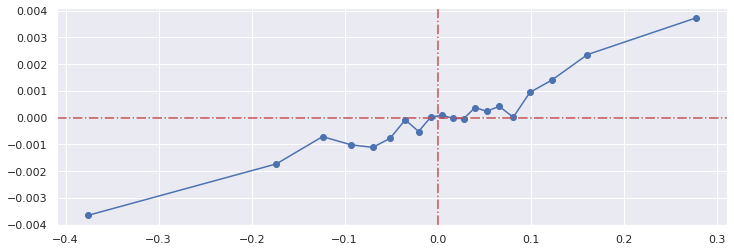

,bin_cut,x,y
0,"(-1.347, -0.213]",-0.376156,-0.003655
1,"(-0.213, -0.144]",-0.173441,-0.001728
2,"(-0.144, -0.107]",-0.123836,-0.000707
3,"(-0.107, -0.0804]",-0.092952,-0.001015
4,"(-0.0804, -0.06]",-0.069780,-0.001108
5,"(-0.06, -0.0428]",-0.051182,-0.000771
6,"(-0.0428, -0.0275]",-0.034849,-0.000077
7,"(-0.0275, -0.0138]",-0.020557,-0.000517
8,"(-0.0138, -0.00124]",-0.007435,0.000025
9,"(-0.00124, 0.0106]",0.004814,0.000092


In [24]:
plot_conditional_expectation( np.array(df["preds"]-df["pred_mean"]),np.array(df["return"])-np.array(df["mr"]))

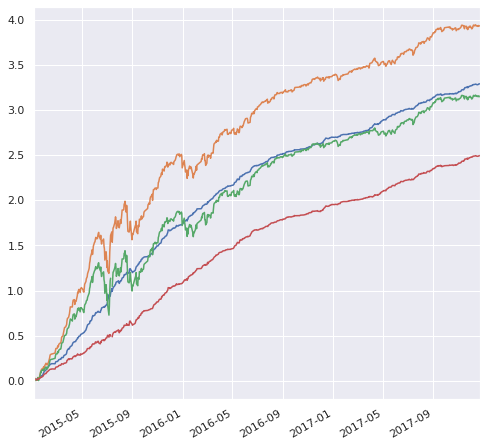

In [91]:
df = pd.DataFrame({"portfolio_return":portfolio_return, "market_return":market_return, "portfolio_limit_return":portfolio_limit_return})
df.index = t
df["date_time"] = t
plt.rcParams['figure.figsize'] = (8, 8)
(df["portfolio_return"]-df["market_return"]).cumsum().plot()
df["portfolio_return"].cumsum().plot()
df["portfolio_limit_return"].cumsum().plot()
(df["portfolio_limit_return"]-df["market_return"]).cumsum().plot()

In [92]:
# plt.rcParams['figure.figsize'] = (8, 8)
# df["market_return"].plot()

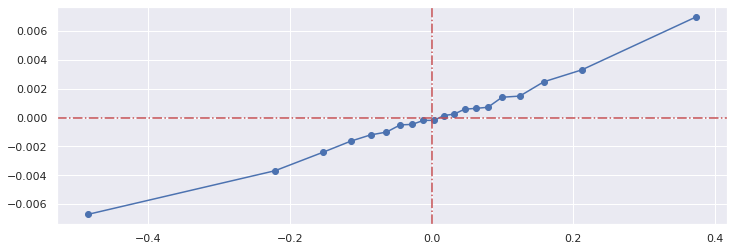

,bin_cut,x,y
0,"(-1.583, -0.277]",-0.485410,-0.006718
1,"(-0.277, -0.18]",-0.221063,-0.003686
2,"(-0.18, -0.132]",-0.154011,-0.002418
3,"(-0.132, -0.0991]",-0.114300,-0.001636
4,"(-0.0991, -0.0744]",-0.086269,-0.001201
5,"(-0.0744, -0.0536]",-0.063715,-0.001006
6,"(-0.0536, -0.0356]",-0.044423,-0.000507
7,"(-0.0356, -0.0194]",-0.027396,-0.000471
8,"(-0.0194, -0.00421]",-0.011701,-0.000194
9,"(-0.00421, 0.0103]",0.003137,-0.000189


In [93]:
plot_conditional_expectation( np.array(data_fin["preds"]-data_fin["pred_mean"]),np.array(data_fin["return"])-np.array(data_fin["mr"]))

In [28]:
# sns.jointplot(
#               x = data_fin["preds"], y = data_fin["return"], 
#               data = data_fin,  #设置数据                                 
#               kind="reg",                                     
#               size = 8, #图表大小(自动调整为正方形))             
#               ratio = 5, #散点图与布局图高度比，整型             
#               marginal_kws = dict(bins=15, rug =True),              
#              )

In [29]:
for y in range(2015,2018):
    temp_df = data_fin[data_fin["date_time"].dt.year == y ]
    print(y, np.corrcoef(temp_df["return"] - temp_df["mr"], temp_df["preds"]-temp_df["pred_mean"])[0,1])

2015 0.1277180009592885
2016 0.13266390326711475
2017 0.08571044190545854


In [30]:
logger.info(np.corrcoef(data_fin["return"] - data_fin["mr"] , data_fin["preds"] -data_fin["pred_mean"])[0,1])

0.12053704850844253


In [31]:
logger.info("dmarketmean_corrcoef(test)")
logger.info(np.corrcoef(data_fin["return"] - data_fin["mr"] , data_fin["preds"])[0,1])

dmarketmean_corrcoef(test)
0.1128547257671306


In [32]:
logger.info("dmarketmean_corrcoef(val)")
logger.info(np.corrcoef(data_te["return"] - data_te["mr"] , data_te["preds"])[0,1])

dmarketmean_corrcoef(val)
0.11451615374083401


In [33]:
logger.info("dmarketmean_corrcoef(train)")
logger.info(np.corrcoef(data_tr["return"] - data_tr["mr"] , data_tr["preds"])[0,1])

dmarketmean_corrcoef(train)
0.2762660123098871


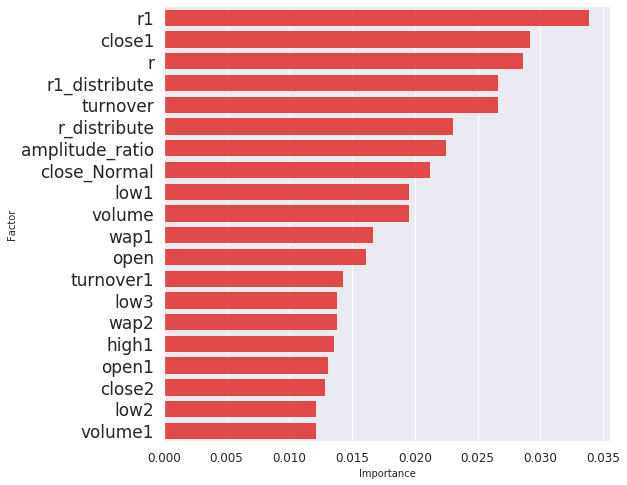

In [34]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.tick_params(labelsize=12)
f_importance_bar(importance_dic)

In [35]:
df_tree = bst.trees_to_dataframe()

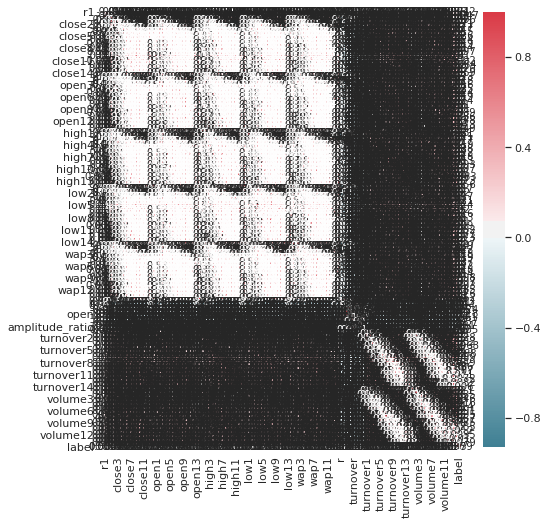

In [36]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_te[use_f+["label"]].corr(), cmap=cmap, annot =True)

In [37]:
all_tree_rounds = bst.best_ntree_limit + early
tr_step = []
te_step = []
fin_step = []
for i in range(1, all_tree_rounds):
    if i % 5==0:
        print("Tree numbers：" ,i ,"best_ntree_limit:", bst.best_ntree_limit, "early_stop:", early)
    temp1 = bst.predict( xgb.DMatrix(data_tr[use_f]),ntree_limit= i)
    temp2 = bst.predict( xgb.DMatrix(data_te[use_f]),ntree_limit= i)
    temp3 = bst.predict( xgb.DMatrix(data_fin[use_f]),ntree_limit= i)
    corrcoef1 = np.corrcoef(temp1, data_tr["return"] - data_tr["mr"])[0,1]
    corrcoef2 = np.corrcoef(temp2, data_te["return"] - data_te["mr"])[0,1]
    corrcoef3 = np.corrcoef(temp3, data_fin["return"] - data_fin["mr"])[0,1]
    tr_rmse = ((temp1 - data_tr["label"])*(temp1 - data_tr["label"])).mean()
    te_rmse = ((temp2 - data_te["label"])*(temp2 - data_te["label"])).mean()
    fin_rmse = ((temp3 - data_fin["label"])*(temp3 - data_fin["label"])).mean()
    tr_step.append([tr_rmse, corrcoef1])
    te_step.append([te_rmse, corrcoef2])
    fin_step.append([fin_rmse, corrcoef3])

Tree numbers： 5 best_ntree_limit: 73 early_stop: 50


KeyboardInterrupt: 

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(np.array(tr_step)[:,0], label="Train")
plt.plot(np.array(te_step)[:,0], label="Val")
plt.plot(np.array(fin_step)[:,0], label="Test")
plt.xlabel("Tree Numbers")
plt.ylabel("RMSE")
plt.vlines(bst.best_ntree_limit, 0.94, 1, colors = "c", linestyles = "dashed")
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(np.array(tr_step)[:,1], label="Train")
plt.plot(np.array(te_step)[:,1], label="Val")
plt.plot(np.array(fin_step)[:,1], label="Test")
plt.xlabel("Tree Numbers")
plt.ylabel("Corr")
plt.vlines(bst.best_ntree_limit, 0.05, 0.25, colors = "c", linestyles = "dashed")
plt.legend()

In [ ]:
all_tree_rounds = bst.best_ntree_limit + early
zero = []
leave_node = []
tree_node = []
for tree_id in range(1, all_tree_rounds):
    zero.append(df_tree[(df_tree["Tree"] == tree_id)  & (df_tree["Feature"] == "Leaf") & (df_tree["Gain"] == 0)].shape[0])
    leave_node.append(df_tree[(df_tree["Tree"] == tree_id)  & (df_tree["Feature"] == "Leaf")].shape[0])
    tree_node.append(df_tree[(df_tree["Tree"] == tree_id)].shape[0])

In [ ]:
zero = np.array(zero)
plt.rcParams['figure.figsize'] = (6, 6)
leave_node = np.array(leave_node)
tree_node = np.array(tree_node)
plt.vlines(bst.best_ntree_limit, 0.35, 0.65, colors = "r", linestyles = "dashed")
plt.xlabel("Tree Numbers")
plt.ylabel("z_ratio(zero_leave / leave)")
zr = np.mean(zero/leave_node)
plt.text(10, 0.65, r"z_ratio mean: %.2f" %(zr) , fontsize=15)
plt.plot(zero/leave_node)

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.text(20, 120, r"Average leave_node: %.2f" %(np.mean(leave_node)) , fontsize=15)
plt.xlabel("Tree Numbers")
plt.ylabel("Leave_Node Nums")
plt.plot(tree_node)
plt.vlines(bst.best_ntree_limit, 50, 120, colors = "r", linestyles = "dashed")

In [119]:
tb = datetime.datetime(2015,7,1)
te = datetime.datetime(2018,1,1)
data_sim = data[ (data["date_time"] >= tb)&(data["date_time"] < te)]
sim_pred =  bst.predict(xgb.DMatrix(data_sim[use_f]), ntree_limit=bst.best_ntree_limit)

In [120]:
data_sim["preds"] = sim_pred
data_sim = data_sim.reset_index(drop=True)
gb = data_sim.groupby(['date_time'])['preds']
data_sim["pred_mean"] = gb.transform(lambda x: x.mean())
data_sim["preds"] = data_sim["preds"] - data_sim["pred_mean"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
data_sim[(data_sim["unique_symbol"] == 600387) & (data_sim["date_time"].dt.month == 7)][["preds","limit_tag","label","date_time","return","mr","r1"]]

,preds,limit_tag,label,date_time,return,mr,r1
73,-0.407153,0,0.374933,2015-07-01,-0.100145,-0.117222,-0.100131
501,-0.438847,0,-1.293784,2015-07-02,-0.032258,0.048654,-0.100145
931,-0.468341,0,-0.374310,2015-07-03,-0.162778,-0.135682,-0.029570
1344,-0.051036,0,1.881296,2015-07-06,0.100199,-0.083546,-0.099761
1726,0.332485,1,-0.478805,2015-07-07,0.031363,0.070827,0.100199
2925,0.407650,0,-0.355780,2015-07-13,-0.032353,-0.014002,0.031062
3315,0.092939,0,-1.356310,2015-07-14,-0.140426,-0.083319,-0.037719
3634,-0.171618,0,-0.327679,2015-07-15,0.039604,0.052852,-0.084795
4024,0.113244,0,-0.861305,2015-07-16,0.044898,0.068924,0.002386
4423,0.332305,0,1.911564,2015-07-17,0.052734,-0.003070,-0.010303


In [100]:
data_sim[(data_sim["r1"]<-0.099) ]

,unique_symbol,date_time,close,turnover,open,high,low,volume,use_tag,adjustment,...,amplitude_ratio,r_distribute,r1_distribute,close_rank,close_Normal,close_std,turnover_rank,volume_rank,preds,pred_mean
73,600387,2015-07-01,0.098763,-3.334919,0.018450,22.97,22.97,-3.334919,1,0.0,...,0.000000,1.734829,-4.235797,289.0,-1.158679,0.067286,1.0,1.0,-0.407153,0.326945
437,600026,2015-07-02,-0.567029,-0.891472,-0.559649,13.60,11.75,-0.891472,1,0.0,...,0.675676,-0.518224,-1.561553,124.0,-1.610815,0.050745,431.0,431.0,0.107623,0.220435
463,600171,2015-07-02,0.004284,-1.150612,-0.022262,21.00,19.81,-1.307350,1,0.0,...,1.000000,0.707438,-1.571862,278.0,-1.174036,0.088470,289.0,221.0,0.130562,0.220435
465,600198,2015-07-02,0.635139,-0.966557,0.589015,31.50,28.71,-1.225219,1,0.0,...,0.498208,1.032957,-1.572292,362.0,-1.008919,0.062468,386.0,255.0,0.264098,0.220435
489,600376,2015-07-02,-0.292714,-0.896320,-0.340664,16.77,15.62,-0.919227,1,0.0,...,0.556522,1.244615,-1.569730,222.0,-1.304807,0.077941,428.0,414.0,-0.041385,0.220435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245399,300134,2017-09-01,0.263694,-2.342222,0.278609,21.02,21.02,-2.342222,1,0.0,...,0.000000,-0.434352,-9.408611,381.0,-1.166406,0.005481,30.0,30.0,-0.088583,-0.001062
245878,300134,2017-09-04,0.126806,-3.220427,0.133985,18.92,18.92,-2.665824,1,0.0,...,0.000000,-0.313069,-10.927232,346.5,-1.221862,0.051153,2.0,12.0,-0.305225,0.023467
254894,2194,2017-09-29,-0.111130,-1.048809,-0.199370,15.11,13.10,-1.055678,1,0.0,...,0.751244,6.318128,-9.241231,282.0,-1.347890,0.079614,467.0,462.0,0.082212,0.034971
255022,300291,2017-09-29,0.060982,-2.895901,0.067064,17.93,17.93,-2.671050,1,-0.1,...,0.000000,-0.355092,-9.232832,331.0,-1.257508,0.014240,6.0,12.0,-0.532011,0.034971


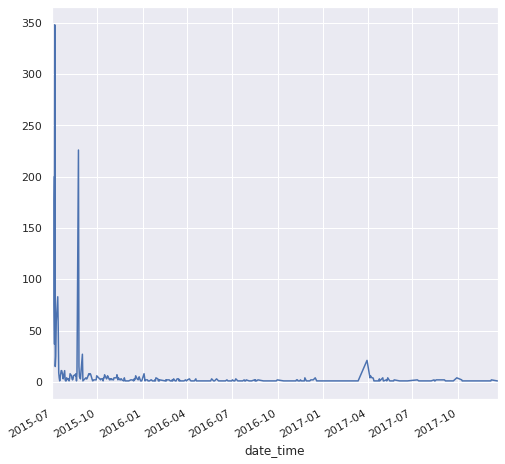

In [101]:
data_sim[(data_sim["r1"]<-0.099) | (data_sim["r1"]>0.099)].groupby(["date_time"])["unique_symbol"].count().plot()

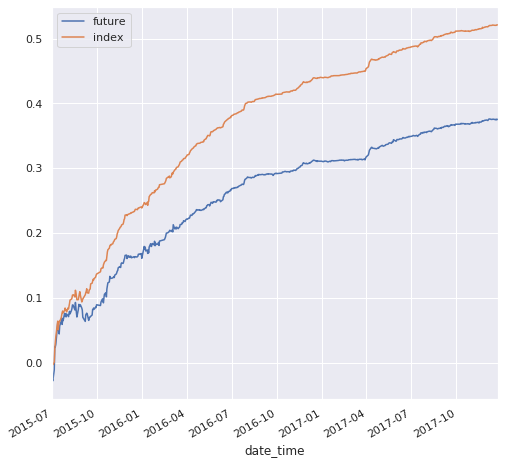

In [130]:
data_sim["preds+"] = data_sim["preds"].apply(lambda x: x if x>=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["future500_return"])
data_sim["pnl_byweightI1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweightF1 = data_sim.groupby(['date_time'])['pnl_byweightF1'].sum()*0.008
pnl_byweightI1 = data_sim.groupby(['date_time'])['pnl_byweightI1'].sum()*0.008
pnl_byweightF1.cumsum().plot(label = "future")
pnl_byweightI1.cumsum().plot(label = "index")
plt.legend()

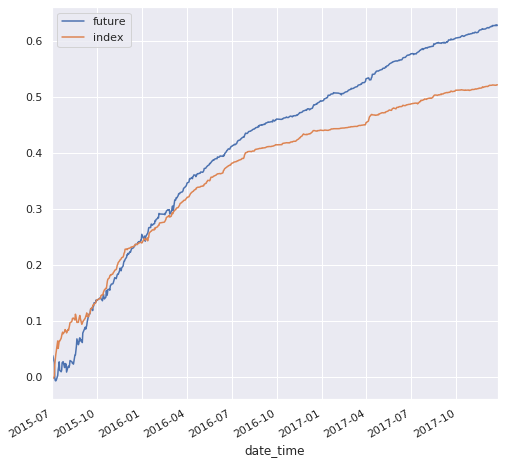

In [131]:
data_sim["preds-"] = data_sim["preds"].apply(lambda x: x if x<=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightI2"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
data_sim["pnl_byweightF2"] =  data_sim["preds-"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF2 = data_sim.groupby(['date_time'])['pnl_byweightF2'].sum()*0.008
pnl_byweightI2 = data_sim.groupby(['date_time'])['pnl_byweightI2'].sum()*0.008
pnl_byweightF2.cumsum().plot(label = "future")
pnl_byweightI2.cumsum().plot(label = "index")
plt.legend()

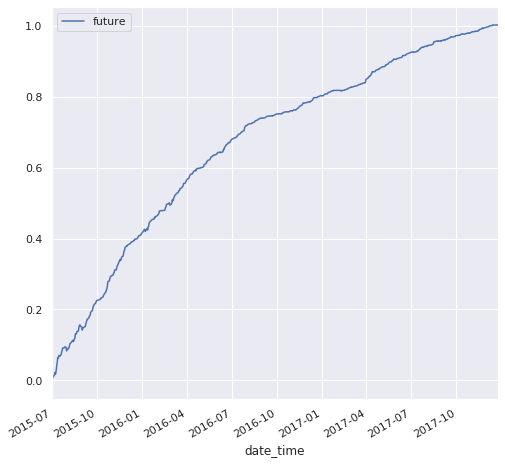

In [149]:
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF"] = data_sim["preds"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF = data_sim.groupby(['date_time'])['pnl_byweightF'].sum()*0.008
pnl_byweightF.cumsum().plot(label = "future")
plt.legend()

In [105]:
# last = data_sim.loc[0]
# data_sim["l"] = 0
# for index,row in data_sim.iterrows():
# #     print(last["preds"], row["preds"])
#     if row["r1"] >= 0.099:
#         print(data_sim.loc[index, "preds"])
#         #row["preds"] = min(row["preds"], last['preds'])
#         data_sim.loc[index, "preds"] = min(row["preds"], last['preds'])
#         print(data_sim.loc[index, "preds"])
#         print("!!!!!!!!!!!!!!!")
#         row["l"] = 1
#     if row["r1"] <= -0.099:
#         row["preds"] = max(row["preds"], last['preds'])
#         row["l"] = -1
#     last = row

# gb = data_sim.groupby(["unique_symbol"])
# data_sim["yesterday_preds"] = gb["preds"].shift(1)
# data_sim["preds"] = data_sim.apply(lambda x: min(x["preds"], x["yesterday_preds"]) if x["r1"] >= 0.099 else x["preds"], axis=1)
# data_sim["preds"] = data_sim.apply(lambda x: max(x["preds"], x["yesterday_preds"]) if x["r1"] <= -0.099 else x["preds"], axis=1)

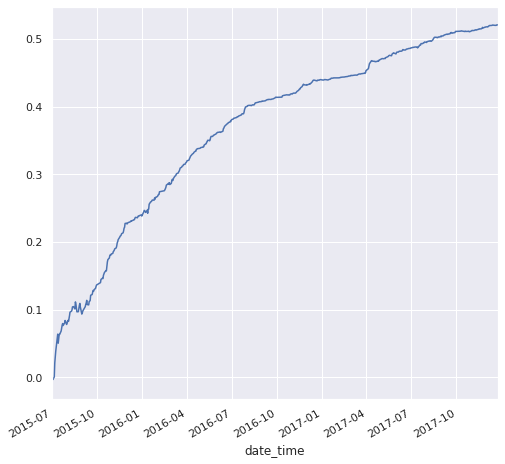

In [106]:
data_sim["preds+"] = data_sim["preds"].apply(lambda x: x if x>=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweight1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweight1 = data_sim.groupby(['date_time'])['pnl_byweight1'].sum()*0.008
pnl_byweight1.cumsum().plot()

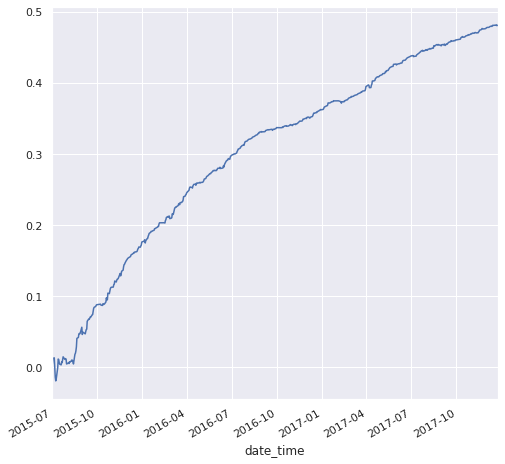

In [107]:
data_sim["preds-"] = data_sim["preds"].apply(lambda x: x if x<=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweight2"] =  data_sim["preds-"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweight2 = data_sim.groupby(['date_time'])['pnl_byweight2'].sum()*0.008
pnl_byweight2.cumsum().plot()

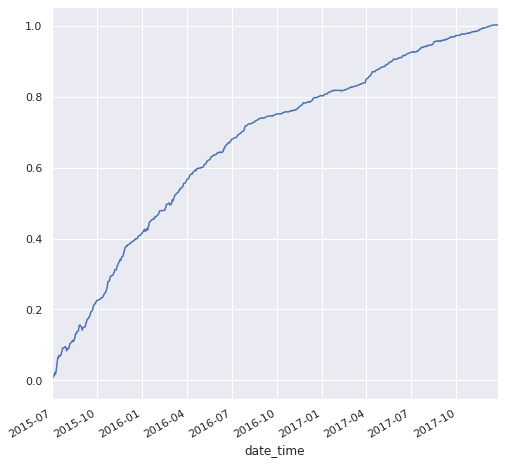

In [108]:
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweight"] = data_sim["preds"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweight = data_sim.groupby(['date_time'])['pnl_byweight'].sum()*0.008
pnl_byweight.cumsum().plot()

In [109]:
sim_df = data_sim[["date_time","preds","unique_symbol"]].copy()

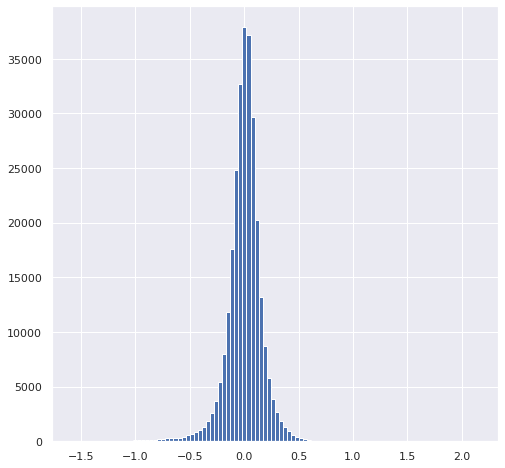

In [110]:
data_sim["preds"].hist(bins= 100)

In [111]:
data_sim.loc[data_sim["preds"].argmin():][["unique_symbol","preds","label","return","r1","date_time"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


,unique_symbol,preds,label,return,r1,date_time
8022,2025,-1.581931,3.790206,0.066111,0.031098,2015-07-29
8023,2028,-0.012053,-0.692937,-0.064927,-0.009748,2015-07-29
8024,2029,0.238506,0.174128,-0.039583,-0.016405,2015-07-29
8025,2022,0.270612,-1.340056,-0.083841,-0.019461,2015-07-29
8026,2050,-0.106416,-0.411513,-0.056701,-0.011224,2015-07-29
...,...,...,...,...,...,...
281539,300026,-0.185025,0.158893,0.009390,-0.001171,2017-12-25
281540,300039,0.233560,-0.012064,0.006525,-0.005682,2017-12-25
281541,300043,-0.347114,0.186499,0.009852,0.001645,2017-12-25
281542,300001,0.065495,0.318648,0.012066,0.002264,2017-12-25


In [112]:
data_sim["preds"].quantile(q=0.8)

0.10330443680286408

In [113]:
def get_forecast(data_sim):
    
    data_sim["date_time"] = data_sim["date_time"] + datetime.timedelta(hours=9.5)
    data_sim["date_time"] = data_sim["date_time"].apply(lambda x:str(x))
    data_sim["unique_symbol"] = data_sim["unique_symbol"].apply(lambda x:str(x))
    data_sim["unique_symbol"]  = data_sim["unique_symbol"].apply(lambda x: x if len(x)==6 else (6-len(x))*"0"+x)
    data_sim["unique_symbol"]  = data_sim["unique_symbol"].apply(lambda x: str(104060)+x)
    data_sim = data_sim.reset_index(drop = True)
    symbol = sorted(list(set(data_sim["unique_symbol"])))
    timestamp = sorted(list(set(data_sim["date_time"])))
    forecast = []
    for s in range(len(symbol)):
        forecast.append(np.array([0]*len(timestamp)))
    forecast = np.array(forecast, dtype=np.float)
    
    
    for _, row in enumerate(data_sim.values):
        if _%5000 == 0:
            print(_, len(data_sim))
        for t in range(len(timestamp)):
            if timestamp[t] == row[0]:
                break
        for s in range(len(symbol)):
            if symbol[s] == row[2]:
                break
#         print(row[1])
        forecast[s][t] = row[1]
    forecast_df = pd.DataFrame()
    
    for i in range(len(symbol)):
        forecast_df[symbol[i]] = forecast[i][:-1]
        
    timestamp = timestamp[1:]
    forecast_df.index = timestamp
    forecast_df.to_csv( '/home/huandong/sim_data/forecast.csv',index=None, header=None)
    timestamp_df = pd.DataFrame({"timestamp":timestamp})
    timestamp_df["timestamp"] = timestamp_df["timestamp"].apply(lambda x:x.replace('-',""))
    timestamp_df.to_csv( '/home/huandong/sim_data/timestamp.csv',index=None, header=None)
    symbol_df = pd.DataFrame({"symbol":symbol})
    symbol_df.to_csv( '/home/huandong/sim_data/symbol.csv',index=None, header=None)
    
    return forecast_df

In [114]:
import datetime
forecast_df = get_forecast(sim_df)

0 281544
5000 281544
10000 281544
15000 281544
20000 281544
25000 281544
30000 281544
35000 281544
40000 281544
45000 281544
50000 281544
55000 281544
60000 281544
65000 281544
70000 281544
75000 281544
80000 281544
85000 281544
90000 281544
95000 281544
100000 281544
105000 281544
110000 281544
115000 281544
120000 281544
125000 281544
130000 281544
135000 281544
140000 281544
145000 281544
150000 281544
155000 281544
160000 281544
165000 281544
170000 281544
175000 281544
180000 281544
185000 281544
190000 281544
195000 281544
200000 281544
205000 281544
210000 281544
215000 281544
220000 281544
225000 281544
230000 281544
235000 281544
240000 281544
245000 281544
250000 281544
255000 281544
260000 281544
265000 281544
270000 281544
275000 281544
280000 281544


In [115]:
forecast_df

,104060000006,104060000008,104060000012,104060000021,104060000025,104060000027,104060000028,104060000030,104060000031,104060000039,...,104060603766,104060603799,104060603806,104060603816,104060603866,104060603868,104060603877,104060603883,104060603888,104060603899
2015-07-02 09:30:00,0.143457,0.0,-0.633517,0.064089,0.000000,0.000000,-0.272548,0.074940,0.121728,0.000000,...,-0.307495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.047051
2015-07-03 09:30:00,-0.247388,0.0,0.370920,-0.009558,0.000000,0.000000,-0.302311,0.048158,-0.043294,0.000000,...,-0.122175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.232688
2015-07-06 09:30:00,0.033675,0.0,-0.084891,-0.061801,0.000000,0.000000,-0.098957,0.062920,-0.341575,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.354043
2015-07-07 09:30:00,-0.129075,0.0,-0.119099,-0.158747,0.000000,0.000000,-0.161479,0.057605,-0.122949,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016811
2015-07-08 09:30:00,-0.094930,0.0,-0.079027,0.349458,0.000000,0.000000,-0.070203,0.077309,-0.234096,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-19 09:30:00,0.000000,0.0,-0.096187,-0.126936,0.050252,0.004216,0.152065,0.000000,0.000000,-0.139335,...,0.194454,-0.022820,0.038428,-0.009114,0.073551,-0.051092,0.038634,-0.213321,-0.141897,0.000000
2017-12-20 09:30:00,0.000000,0.0,-0.056601,-0.067138,0.058518,0.052258,-0.078026,0.000000,0.000000,0.146928,...,-0.004515,0.099627,-0.118669,-0.105396,0.126997,-0.264422,0.057087,-0.093198,-0.055783,0.000000
2017-12-21 09:30:00,0.000000,0.0,0.024041,0.051043,-0.152230,0.093278,0.004111,0.000000,0.000000,0.117475,...,-0.059797,-0.048791,0.018228,0.013896,-0.019622,-0.000226,0.059350,0.143494,-0.134937,0.000000
2017-12-22 09:30:00,0.000000,0.0,-0.062000,-0.228973,0.020703,0.063319,0.001263,0.000000,0.000000,-0.076804,...,-0.057337,0.262859,0.035148,-0.158830,0.081619,-0.142231,0.171258,-0.037714,0.092701,0.000000


In [96]:
data_sim[data_sim["unique_symbol"] == 12][["unique_symbol","date_time","preds"]]

,unique_symbol,date_time,preds
232,12,2015-07-01,-0.633517
653,12,2015-07-02,0.370920
1074,12,2015-07-03,-0.084891
1483,12,2015-07-06,-0.119099
1868,12,2015-07-07,-0.079027
...,...,...,...
279464,12,2017-12-19,-0.056601
279931,12,2017-12-20,0.024041
280399,12,2017-12-21,-0.062000
280864,12,2017-12-22,-0.051520


In [ ]:
f = pd.read_csv("/home/huandong/sim_data/forecast.csv",header= None)

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(f.values.sum(axis=1))